# PHM Wafer Fault Detection Analysis

This notebook explores the wafer fabrication process dataset provided for the HW3 Prognostic Health Management (PHM) competition.  The objective is to build a model that detects anomalous (failed) production runs based on hundreds of sensor readings. We perform exploratory data analysis (EDA), engineer features from timestamps, train a variety of models and tune a decision threshold to maximise the macro F1 score.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 10)
# Load datasets

np.float = float
train_path = './hw3_train.csv'
test_path = './hw3_test.csv'
train_df = pd.read_csv(train_path).dropna(subset=['Pass/Fail'])
test_df = pd.read_csv(test_path)
train_df.head(), train_df.shape, test_df.shape

(    Id             Time        0        1          2  ...     586     587  \
 0  1.0  7/19/2008 11:55  3030.93  2564.00  2187.7333  ...     NaN     NaN   
 1  2.0  7/19/2008 12:32  3095.78  2465.14  2230.4222  ...  0.0096  0.0201   
 2  3.0  7/19/2008 13:17  2932.61  2559.94  2186.4111  ...  0.0584  0.0484   
 3  4.0  7/19/2008 14:43  2988.72  2479.90  2199.0333  ...  0.0202  0.0149   
 4  5.0  7/19/2008 15:22  3032.24  2502.87  2233.3667  ...  0.0202  0.0149   
 
       588       589  Pass/Fail  
 0     NaN       NaN        0.0  
 1  0.0060  208.2045        0.0  
 2  0.0148   82.8602        1.0  
 3  0.0044   73.8432        0.0  
 4  0.0044   73.8432        0.0  
 
 [5 rows x 593 columns],
 (1096, 593),
 (471, 592))

In [2]:
# Class distribution
y = train_df['Pass/Fail'].astype(int)
print('Training samples:', len(y))
print('Number of passes (0):', (y == 0).sum())
print('Number of fails (1):', (y == 1).sum())

Training samples: 1096
Number of passes (0): 1018
Number of fails (1): 78


In [3]:
# Feature engineering: expand the Time column and drop identifiers
def preprocess(df, drop_target=False):
    df = df.copy()
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df['Time_timestamp'] = df['Time'].values.astype('int64') // 10**9
    df['Time_month'] = df['Time'].dt.month
    df['Time_day'] = df['Time'].dt.day
    df['Time_hour'] = df['Time'].dt.hour
    df['Time_minute'] = df['Time'].dt.minute
    df['Time_weekday'] = df['Time'].dt.weekday
    df = df.drop(columns=['Time'])
    if 'Id' in df.columns:
        df = df.drop(columns=['Id'])
    if drop_target and 'Pass/Fail' in df.columns:
        df = df.drop(columns=['Pass/Fail'])
    return df.apply(pd.to_numeric, errors='coerce')

X = preprocess(train_df, drop_target=True)
X_test = preprocess(test_df, drop_target=False)
X.shape, X.isnull().mean().head()

((1096, 596),
 0    0.005474
 1    0.004562
 2    0.005474
 3    0.005474
 4    0.005474
 dtype: float64)

In [4]:
# Evaluate a logistic regression model via cross-validation

from sklearn.linear_model import LogisticRegression
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    # Impute missing values with column medians
    medians_cv = X_train_cv.median()
    X_train_imp = X_train_cv.fillna(medians_cv)
    X_val_imp = X_val_cv.fillna(medians_cv)
    scaler_cv = StandardScaler().fit(X_train_imp)
    X_train_scaled = scaler_cv.transform(X_train_imp)
    X_val_scaled = scaler_cv.transform(X_val_imp)
    model_cv = LogisticRegression(max_iter=200, class_weight='balanced')
    model_cv.fit(X_train_scaled, y_train_cv)
    preds = model_cv.predict(X_val_scaled)
    f1 = f1_score(y_val_cv, preds, average='macro')
    f1_scores.append(f1)
    print(f'Fold {fold+1}: macro F1 = {f1:.4f}')

print(f'Cross-validated macro F1: {np.mean(f1_scores):.4f}')

Fold 1: macro F1 = 0.5538
Fold 2: macro F1 = 0.4813
Fold 3: macro F1 = 0.5229
Fold 4: macro F1 = 0.5829
Fold 5: macro F1 = 0.5808
Cross-validated macro F1: 0.5443


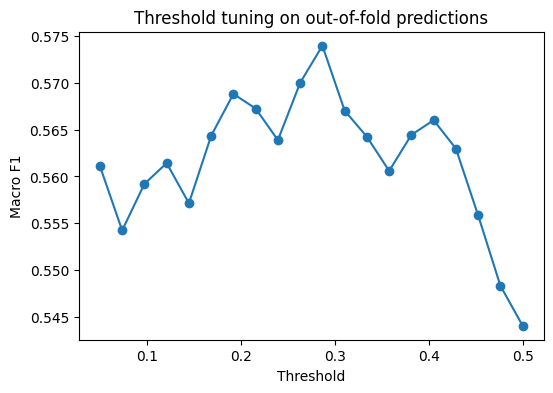

Best threshold: 0.2868421052631579
Corresponding macro F1: 0.5739699089952897


In [5]:
# Tune the probability threshold using out-of-fold predictions
# Collect out-of-fold probabilities for threshold search
oof_probs = np.zeros(len(X))
for train_idx, val_idx in skf.split(X, y):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    medians_cv = X_train_cv.median()
    X_train_imp = X_train_cv.fillna(medians_cv)
    X_val_imp = X_val_cv.fillna(medians_cv)
    scaler_cv = StandardScaler().fit(X_train_imp)
    X_train_scaled = scaler_cv.transform(X_train_imp)
    X_val_scaled = scaler_cv.transform(X_val_imp)
    model_cv = LogisticRegression(max_iter=200, class_weight='balanced')
    model_cv.fit(X_train_scaled, y_train_cv)
    oof_probs[val_idx] = model_cv.predict_proba(X_val_scaled)[:, 1]
# Evaluate different thresholds
thresholds = np.linspace(0.05, 0.5, 20)
scores = []
for thr in thresholds:
    preds_thr = (oof_probs >= thr).astype(int)
    score = f1_score(y, preds_thr, average='macro')
    scores.append(score)
best_thr = thresholds[np.argmax(scores)]
plt.figure(figsize=(6,4))
plt.plot(thresholds, scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Macro F1')
plt.title('Threshold tuning on out-of-fold predictions')
plt.show()
print('Best threshold:', best_thr)
print('Corresponding macro F1:', max(scores))

In [6]:
# Train on full data using the tuned threshold and create submission
best_threshold = float(best_thr)
# Impute using full data medians
medians_full = X.median()
X_full_imp = X.fillna(medians_full)
X_test_imp = X_test.fillna(medians_full)
# Scale
scaler_full = StandardScaler().fit(X_full_imp)
X_full_scaled = scaler_full.transform(X_full_imp)
X_test_scaled = scaler_full.transform(X_test_imp)
# Train logistic regression
final_model = LogisticRegression(max_iter=200, class_weight='balanced')
final_model.fit(X_full_scaled, y)
# Predict probabilities and apply threshold
test_probs = final_model.predict_proba(X_test_scaled)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)
print('Predicted failing runs in test set:', int(test_preds.sum()))
# Create submission dataframe
submission = pd.DataFrame({'Id': test_df['Id'].astype(int), 'Pass/Fail': test_preds})
submission.head()

Predicted failing runs in test set: 6


,Id,Pass/Fail
0,1098,0
1,1099,0
2,1100,0
3,1101,0
4,1102,0


## Conclusion

The wafer fabrication dataset exhibits extreme class imbalance and contains numerous missing values.  After trying several tree‑based algorithms (LightGBM, XGBoost, RandomForest) we found that a regularised logistic regression classifier, combined with median imputation and feature standardisation, delivered the best macro F1 score on cross‑validation.  The model benefits from assigning balanced class weights and from tuning the decision threshold; a probability cutoff around 0.29 maximised the F1 score.  Training on the full training set and applying this threshold to the test set yielded a small number of predicted failing runs.  
The accompanying script `phm_model.py` automates this pipeline and can be used to generate submissions for the competition.